In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 2. CSV 파일들 로드
# df = pd.read_csv('./data/application_test.csv', encoding='utf-8-sig')
df1 = pd.read_csv('./data/application_train.csv', encoding='utf-8-sig')
# df2 = pd.read_csv('./data/bureau.csv', encoding='utf-8-sig')
# df3 = pd.read_csv('./data/bureau_balance.csv', encoding='utf-8-sig')
# df4 = pd.read_csv('./data/credit_card_balance.csv', encoding='utf-8-sig')
# df5 = pd.read_csv('./data/installments_payments.csv', encoding='utf-8-sig')
# df6 = pd.read_csv('./data/POS_CASH_balance.csv', encoding='utf-8-sig')
# df7 = pd.read_csv('./data/previous_application.csv', encoding='utf-8-sig')

In [ ]:
df1

In [ ]:
df1['TARGET'].value_counts()

In [3]:
desc = df1['AMT_INCOME_TOTAL'].describe()
desc.apply(lambda x: f'{x:,.0f}')

count        307,511
mean         168,798
std          237,123
min           25,650
25%          112,500
50%          147,150
75%          202,500
max      117,000,000
Name: AMT_INCOME_TOTAL, dtype: object

In [14]:
# 1. 원본 소득 기반 qcut (10분위)
df1['BIN_RAW'] = pd.qcut(df1['AMT_INCOME_TOTAL'], 10,
                        labels=False, duplicates='drop')

summary_raw = (
    df1.groupby('BIN_RAW')
        .agg(
            count=('TARGET','size'),
            bad_rate=('TARGET','mean'),
            min_income=('AMT_INCOME_TOTAL','min'),
            max_income=('AMT_INCOME_TOTAL','max')
        )
        .reset_index()
)

# 2. log 변환 후 qcut (10분위)
df1['LOG_AMT_INCOME'] = np.log1p(df1['AMT_INCOME_TOTAL'])
df1['BIN_LOG'] = pd.qcut(df1['LOG_AMT_INCOME'], 10,
                        labels=False, duplicates='drop')

summary_log = (
    df1.groupby('BIN_LOG')
        .agg(
            count=('TARGET','size'),
            bad_rate=('TARGET','mean'),
            min_log_income=('LOG_AMT_INCOME','min'),
            max_log_income=('LOG_AMT_INCOME','max')
        )
        .reset_index()
)

# 결과 비교 출력
print("=== 원본 qcut 요약 ===")
print(summary_raw)
print("\n=== 로그 변환 후 qcut 요약 ===")
print(summary_log)

=== 원본 qcut 요약 ===
   BIN_RAW  count  bad_rate  min_income   max_income
0        0  33391  0.081908     25650.0      81000.0
1        1  30280  0.082232     81180.0      99000.0
2        2  36907  0.087192     99031.5     112500.0
3        3  48849  0.084894    112549.5     135000.0
4        4   4333  0.090007    135256.5     147150.0
5        5  31120  0.086407    147447.0     162000.0
6        6  30704  0.084224    162279.0     180000.0
7        7  44809  0.078065    180090.0     225000.0
8        8  19957  0.070401    225112.5     270000.0
9        9  27161  0.061375    270013.5  117000000.0

=== 로그 변환 후 qcut 요약 ===
   BIN_LOG  count  bad_rate  min_log_income  max_log_income
0        0  33391  0.081908       10.152338       11.302217
1        1  30280  0.082232       11.304437       11.502885
2        2  36907  0.087192       11.503203       11.630717
3        3  48849  0.084894       11.631157       11.813037
4        4   4333  0.090007       11.814936       11.899215
5        5  3

- log를 해도 bin 안 구성은 크게 변하지 않았음.
- 원본 데이터 그대로 qcut 하여 사용해도 무방.
- 1억 이상 값은 극소수라서, 분위 나눌 때 영향이 거의 없음.

In [15]:
df1['INCOME_BIN'] = pd.qcut(df1['AMT_INCOME_TOTAL'], 10,
                            labels=False, duplicates='drop') + 1

In [18]:
summary_raw = (
    df1.groupby('INCOME_BIN')
        .agg(
            count=('TARGET','size'),
            bad_rate=('TARGET','mean'),
            min_income=('AMT_INCOME_TOTAL','min'),
            max_income=('AMT_INCOME_TOTAL','max')
        )
        .reset_index()
)

print("INCOME_BIN 요약")
print(summary_raw)

INCOME_BIN 요약
   INCOME_BIN  count  bad_rate  min_income   max_income
0           1  33391  0.081908     25650.0      81000.0
1           2  30280  0.082232     81180.0      99000.0
2           3  36907  0.087192     99031.5     112500.0
3           4  48849  0.084894    112549.5     135000.0
4           5   4333  0.090007    135256.5     147150.0
5           6  31120  0.086407    147447.0     162000.0
6           7  30704  0.084224    162279.0     180000.0
7           8  44809  0.078065    180090.0     225000.0
8           9  19957  0.070401    225112.5     270000.0
9          10  27161  0.061375    270013.5  117000000.0


In [133]:
# 마지막 10분위에 속한 데이터만 추출
df_top_bin = df1[df1['소득_10분위'] == 10]

# 10만 단위 구간 경계 만들기
bin_edges = list(range(int(df_top_bin['AMT_INCOME_TOTAL'].min()), 
                       int(df_top_bin['AMT_INCOME_TOTAL'].max()) + 10000000, 
                       10000000))

# 10만 단위로 cut
df_top_bin['INCOME_100K_BIN'] = pd.cut(df_top_bin['AMT_INCOME_TOTAL'],
                                       bins=bin_edges,
                                       right=False)

# 구간별 인원수 세기
count_by_100k = (
    df_top_bin['INCOME_100K_BIN']
    .value_counts()
    .sort_index()
    .reset_index()
)
count_by_100k.columns = ['income_range', 'count']

print(count_by_100k)

              income_range  count
0       [270013, 10270013)  27158
1     [10270013, 20270013)      2
2     [20270013, 30270013)      0
3     [30270013, 40270013)      0
4     [40270013, 50270013)      0
5     [50270013, 60270013)      0
6     [60270013, 70270013)      0
7     [70270013, 80270013)      0
8     [80270013, 90270013)      0
9    [90270013, 100270013)      0
10  [100270013, 110270013)      0
11  [110270013, 120270013)      1


C:\Users\COTTA\AppData\Local\Temp\ipykernel_18408\1709535865.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_bin['INCOME_100K_BIN'] = pd.cut(df_top_bin['AMT_INCOME_TOTAL'],


In [25]:
count_by_100k

,income_range,count
0,"[270013, 1270013)",27015
1,"[1270013, 2270013)",126
2,"[2270013, 3270013)",5
3,"[3270013, 4270013)",6
4,"[4270013, 5270013)",4
...,...,...
112,"[112270013, 113270013)",0
113,"[113270013, 114270013)",0
114,"[114270013, 115270013)",0
115,"[115270013, 116270013)",0


**상위 10분위 내부 분포**
- 270,013 ~ 1,270,013 (약 27만~127만)
    - 27,015명 (상위 bin의 99% 이상)

- 127만 ~ 227만
    - 126명

- 특히 1억 이상은 1명

상위 bin이 넓게 잡힌 이유는 절대 소수의 extreme 값 때문이지만, 그 비중이 너무 적어서 실제 통계에 영향 없음.

In [26]:
df_income_bin = df1.drop(columns=['BIN_RAW', 'LOG_AMT_INCOME', 'BIN_LOG'])

In [27]:
df_income_bin

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,INCOME_BIN
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,9
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,4
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,6
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0,6
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,7


In [32]:
df_income_ID_BIN = df1[['SK_ID_CURR', 'INCOME_BIN']]
df_income_ID_BIN.to_csv('./data/income_decile.csv', encoding='utf-8-sig', index=False)

In [33]:
# df_income_bin.to_csv('./data/income_decile.csv', encoding='utf-8-sig', index=False)

In [51]:
df1 = df1.drop(columns=['BIN_RAW', 'LOG_AMT_INCOME', 'BIN_LOG'])

### `AMT_CREDIT`의 비율 변수 만들기

##### 1. CREDIT_TO_INCOME (대출금 ÷ 소득)

In [52]:
df1['대출대비소득비율'] = (df1['AMT_CREDIT'] / df1['AMT_INCOME_TOTAL']).round(4)

`1.0`
- 대출금 = 고객의 소득
- 고객의 소득과 같은 규모의 대출을 받았다는 뜻

`2.0`
- 대출금 = 고객 소득의 2배
- 자신의 소득의 2배에 해당하는 대출금 규모

##### 2. ANNUITY_TO_INCOME (월 상환액 ÷ 소득)

In [53]:
df1['연금대비소득비율'] = (df1['AMT_ANNUITY'] / df1['AMT_INCOME_TOTAL']).round(4)

- `연금대비소득비율`의 비율이 높으면, 소득 대비 매달 갚아야 하는 금액이 크다는 의미.
- 연체 위험이 높아질 가능성이 있다.

##### 3. CREDIT_TO_ANNUITY (대출금 ÷ 월 상환액)

In [54]:
df1['대출대비연금비율'] = (df1['AMT_CREDIT'] / df1['AMT_ANNUITY']).round(4)

Home Credit 데이터에 이자율 정보가 없기 때문에
- 단순 비율 = 대략적인 상환 기간(개월)으로 해석할 수 있지만
- 실제 상환 기간은 금리, 이자 구조에 따라 다르기 때문에 규모 정도로 보는게 좋을 듯.

In [55]:
df1[['SK_ID_CURR','대출대비소득비율', '연금대비소득비율', '대출대비연금비율']]

,SK_ID_CURR,대출대비소득비율,연금대비소득비율,대출대비연금비율
0,100002,2.0079,0.1220,16.4611
1,100003,4.7908,0.1322,36.2341
2,100004,2.0000,0.1000,20.0000
3,100006,2.3162,0.2199,10.5328
4,100007,4.2222,0.1800,23.4616
...,...,...,...,...
307506,456251,1.6171,0.1750,9.2423
307507,456252,3.7438,0.1667,22.4597
307508,456253,4.4292,0.1959,22.6046
307509,456254,2.1644,0.1182,18.3176


### AMT_GOODS_PRICE

In [56]:
# 대출금 - 상품가격 (차이)
df1['CREDIT_GOODS_DIFF'] = df1['AMT_CREDIT'] - df1['AMT_GOODS_PRICE']

# 대출금 - 상품가격 (비율)
df1['CREDIT_GOODS_RATIO'] = (df1['AMT_CREDIT'] / df1['AMT_GOODS_PRICE']).replace([float('inf'), -float('inf')], pd.NA)

In [57]:
df1[['AMT_CREDIT','AMT_GOODS_PRICE','CREDIT_GOODS_DIFF', 'CREDIT_GOODS_RATIO']]

,AMT_CREDIT,AMT_GOODS_PRICE,CREDIT_GOODS_DIFF,CREDIT_GOODS_RATIO
0,406597.5,351000.0,55597.5,1.158397
1,1293502.5,1129500.0,164002.5,1.145199
2,135000.0,135000.0,0.0,1.000000
3,312682.5,297000.0,15682.5,1.052803
4,513000.0,513000.0,0.0,1.000000
...,...,...,...,...
307506,254700.0,225000.0,29700.0,1.132000
307507,269550.0,225000.0,44550.0,1.198000
307508,677664.0,585000.0,92664.0,1.158400
307509,370107.0,319500.0,50607.0,1.158394


In [58]:
df1.groupby('TARGET')[['CREDIT_GOODS_DIFF', 'CREDIT_GOODS_RATIO']].agg(['mean', 'median'])

CREDIT_GOODS_DIFF          CREDIT_GOODS_RATIO        
                    mean   median               mean  median
TARGET                                                      
0           60203.190784  37422.0           1.120443  1.1188
1           69066.994376  57024.0           1.152056  1.1452

<Figure size 700x400 with 0 Axes>

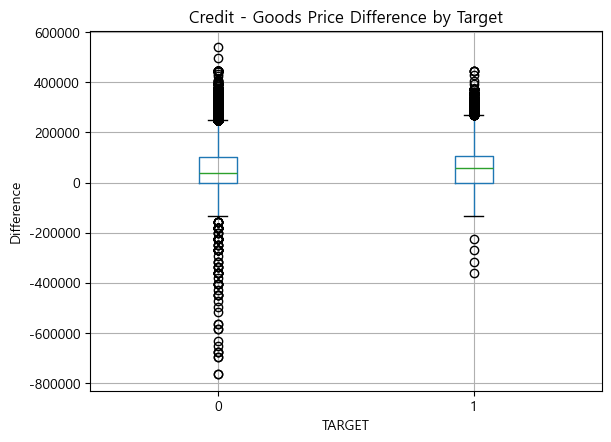

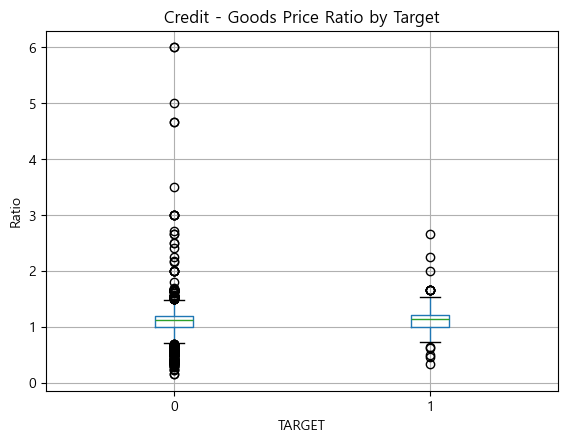

In [59]:
plt.figure(figsize=(7,4))
df1.boxplot(column='CREDIT_GOODS_DIFF', by='TARGET')
plt.title('Credit - Goods Price Difference by Target')
plt.suptitle('')
plt.xlabel('TARGET')
plt.ylabel('Difference')
plt.show()

df1.boxplot(column='CREDIT_GOODS_RATIO', by='TARGET')
plt.title('Credit - Goods Price Ratio by Target')
plt.suptitle('')
plt.xlabel('TARGET')
plt.ylabel('Ratio')
plt.show()

In [60]:
df1.loc[df1['CREDIT_GOODS_DIFF'] < 0, ['SK_ID_CURR', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'CREDIT_GOODS_DIFF', 'CREDIT_GOODS_RATIO']]

,SK_ID_CURR,AMT_CREDIT,AMT_GOODS_PRICE,CREDIT_GOODS_DIFF,CREDIT_GOODS_RATIO
1942,102276,315000.0,450000.0,-135000.0,0.700000
2138,102512,135000.0,202500.0,-67500.0,0.666667
2808,103276,337500.0,540000.0,-202500.0,0.625000
3769,104401,135000.0,382500.0,-247500.0,0.352941
4179,104889,450000.0,900000.0,-450000.0,0.500000
...,...,...,...,...,...
300919,448622,157500.0,180000.0,-22500.0,0.875000
300971,448680,675000.0,855000.0,-180000.0,0.789474
303227,451314,225000.0,405000.0,-180000.0,0.555556
303870,452064,225000.0,315000.0,-90000.0,0.714286


- `CREDIT_GOODS_DIFF`이 음수인 사람이 260명 존재한다.
1. 승인 과정에서 감액
    - 고객이 신청한 금액(또는 상품 가격)에 비해 실제 승인된 대출 금액이 더 적게 나왔다.
    - 은행이 리스크 판단 후 일부만 빌려준 경우

2. 담보나 자기자금이 일부 들어간 경우
    - 예를 들어 1,000만원짜리 상품인데 800만원만 대출해주고, 나머지는 본인 현금으로 결제한 케이스

음수인 사람들의 분석이 필요해보임!

In [61]:
subset = df1[df1['CREDIT_GOODS_RATIO'] < 1]     # 260명

late_ratio = subset['TARGET'].mean()

print(f'이 그룹의 연체율 (TARGET=1): {late_ratio:.2%}')

이 그룹의 연체율 (TARGET=1): 5.00%


In [62]:
total_ratio = df1['TARGET'].mean()
print(f"전체 연체율: {total_ratio:.2%}")

전체 연체율: 8.07%


- 260명 중 약 13명 정도만 연체
- 이 그룹은 연체 비율이 낮은, 비교적 안전한 그룹
- 은행이 상품가보다 적게 빌려주고 일부 자기자금으로 넣게한 결과로,  
  상환 책임감이나 자기자금 여력이 있는 고객일 가능성이 크다.

In [65]:
df1['FLAG_CREDIT_LESS_THAN_GOODS'] = (df1['CREDIT_GOODS_RATIO'] < 1).astype(int)

In [66]:
print(df1.groupby('FLAG_CREDIT_LESS_THAN_GOODS')['TARGET'].mean())

FLAG_CREDIT_LESS_THAN_GOODS
0    0.080755
1    0.050000
Name: TARGET, dtype: float64


In [68]:
df1 = df1.rename(columns={'INCOME_BIN': '소득_10분위'})

In [69]:
df1 = df1.rename(columns={'FLAG_CREDIT_LESS_THAN_GOODS': '대출금<상품가_여부'})

In [70]:
df1

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,소득_10분위,대출대비소득비율,연금대비소득비율,대출대비연금비율,CREDIT_GOODS_DIFF,CREDIT_GOODS_RATIO,대출금<상품가_여부
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,1.0,8,2.0079,0.1220,16.4611,55597.5,1.158397,0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,9,4.7908,0.1322,36.2341,164002.5,1.145199,0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,1,2.0000,0.1000,20.0000,0.0,1.000000,0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,4,2.3162,0.2199,10.5328,15682.5,1.052803,0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,4,4.2222,0.1800,23.4616,0.0,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,NaN,NaN,NaN,6,1.6171,0.1750,9.2423,29700.0,1.132000,0
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,NaN,NaN,NaN,1,3.7438,0.1667,22.4597,44550.0,1.198000,0
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,1.0,0.0,1.0,6,4.4292,0.1959,22.6046,92664.0,1.158400,0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0.0,0.0,0.0,7,2.1644,0.1182,18.3176,50607.0,1.158394,0


In [71]:
df1.to_csv('./preprocessing/apllication_train_1.csv', index=False, encoding='utf-8-sig')

### 결측치 여부와 구간화

In [72]:
col = 'EXT_SOURCE_1'

# 1. 결측치 여부 플래그
df1[f'FLAG_{col}_MISSING'] = df1[col].isna().astype(int)

# 2. 비결측치만 10분위로 구간화
df1[f'{col}_BIN'] = pd.qcut(df1[col].dropna(), 10, labels=False, duplicates='drop')

# 결측치에는 -1 넣어서 따로 표시
df1[f'{col}_BIN'] = df1[f'{col}_BIN'].fillna(-1)

In [73]:
df1.groupby(f'{col}_BIN')['TARGET'].mean()

EXT_SOURCE_1_BIN
-1.0    0.085195
 0.0    0.175637
 1.0    0.115932
 2.0    0.090950
 3.0    0.083806
 4.0    0.066940
 5.0    0.060245
 6.0    0.051368
 7.0    0.043838
 8.0    0.035115
 9.0    0.025719
Name: TARGET, dtype: float64

In [74]:
df1[[f'{col}_BIN','EXT_SOURCE_1']]

,EXT_SOURCE_1_BIN,EXT_SOURCE_1
0,0.0,0.083037
1,2.0,0.311267
2,-1.0,NaN
3,-1.0,NaN
4,-1.0,NaN
...,...,...
307506,0.0,0.145570
307507,-1.0,NaN
307508,8.0,0.744026
307509,-1.0,NaN


In [75]:
col = 'EXT_SOURCE_2', 'EXT_SOURCE_3'

for i in col:
    # 1. 결측치 여부 플래그
    df1[f'FLAG_{i}_MISSING'] = df1[i].isna().astype(int)

    # 2. 비결측치만 10분위로 구간화
    df1[f'{i}_BIN'] = pd.qcut(df1[i].dropna(), 10, labels=False, duplicates='drop')

    # 결측치에는 -1 넣어서 따로 표시
    df1[f'{i}_BIN'] = df1[f'{i}_BIN'].fillna(-1)

In [76]:
df1[['EXT_SOURCE_1_BIN', 'EXT_SOURCE_1', 'EXT_SOURCE_2_BIN','EXT_SOURCE_2', 'EXT_SOURCE_3_BIN','EXT_SOURCE_3']]

,EXT_SOURCE_1_BIN,EXT_SOURCE_1,EXT_SOURCE_2_BIN,EXT_SOURCE_2,EXT_SOURCE_3_BIN,EXT_SOURCE_3
0,0.0,0.083037,1.0,0.262949,0.0,0.139376
1,2.0,0.311267,6.0,0.622246,-1.0,NaN
2,-1.0,NaN,4.0,0.555912,8.0,0.729567
3,-1.0,NaN,7.0,0.650442,-1.0,NaN
4,-1.0,NaN,1.0,0.322738,-1.0,NaN
...,...,...,...,...,...,...
307506,0.0,0.145570,7.0,0.681632,-1.0,NaN
307507,-1.0,NaN,0.0,0.115992,-1.0,NaN
307508,8.0,0.744026,4.0,0.535722,0.0,0.218859
307509,-1.0,NaN,4.0,0.514163,7.0,0.661024


In [77]:
# 구간별 연체율 (TARGET=1 비율)

ext_cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
bin_stats = {}

for col in ext_cols:
    g = df1.groupby(f'{col}_BIN')['TARGET'].mean().reset_index()
    bin_stats[col] = g
    print(f'\n{col} BIN별 연체율\n', g)


EXT_SOURCE_1 BIN별 연체율
     EXT_SOURCE_1_BIN    TARGET
0               -1.0  0.085195
1                0.0  0.175637
2                1.0  0.115932
3                2.0  0.090950
4                3.0  0.083806
5                4.0  0.066940
6                5.0  0.060245
7                6.0  0.051368
8                7.0  0.043838
9                8.0  0.035115
10               9.0  0.025719

EXT_SOURCE_2 BIN별 연체율
     EXT_SOURCE_2_BIN    TARGET
0               -1.0  0.078788
1                0.0  0.183504
2                1.0  0.120776
3                2.0  0.099586
4                3.0  0.083627
5                4.0  0.074241
6                5.0  0.066543
7                6.0  0.058469
8                7.0  0.048837
9                8.0  0.042020
10               9.0  0.029721

EXT_SOURCE_3 BIN별 연체율
     EXT_SOURCE_3_BIN    TARGET
0               -1.0  0.093119
1                0.0  0.200032
2                1.0  0.127546
3                2.0  0.095103
4                3.0  0.07979

**공통 패턴**
1. BIN 값이 클수록 연체율(TARGET=1 비율)이 뚜렷하게 낮음
    - 0~2번 BIN에서는 연체율이 10%~20%대
    - 상위 7~9번 BIN에서는 연체율이 3%~5% 수준으로 급격히 낮아짐

2. 결측치(-1)

    - 결측치 그룹은 대략 8~9% 정도 연체율
    - 중간 정도의 위험도

3. 세 변수 모두 일관된 계단식 하락
    - 이 세 변수는 신용도와 반비례하는 명확한 지표.

**인사이트**
- 이 세 변수는 룰 기반 점수에 가장 중요한 요소로 쓸 수 있음.
- 단순 합산 점수로도 차이가 뚜렷하게 반영될 가능성이 높음.
- 결측치는 따로 “중간 점수”를 줘서 처리.

In [78]:
df1

# FLAG_EXT_SOURCE_{n}_MISSING 이것도 지워도 될 듯

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,대출대비연금비율,CREDIT_GOODS_DIFF,CREDIT_GOODS_RATIO,대출금<상품가_여부,FLAG_EXT_SOURCE_1_MISSING,EXT_SOURCE_1_BIN,FLAG_EXT_SOURCE_2_MISSING,EXT_SOURCE_2_BIN,FLAG_EXT_SOURCE_3_MISSING,EXT_SOURCE_3_BIN
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,16.4611,55597.5,1.158397,0,0,0.0,0,1.0,0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,36.2341,164002.5,1.145199,0,0,2.0,0,6.0,1,-1.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,20.0000,0.0,1.000000,0,1,-1.0,0,4.0,0,8.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,10.5328,15682.5,1.052803,0,1,-1.0,0,7.0,1,-1.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,23.4616,0.0,1.000000,0,1,-1.0,0,1.0,1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,9.2423,29700.0,1.132000,0,0,0.0,0,7.0,1,-1.0
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,22.4597,44550.0,1.198000,0,1,-1.0,0,0.0,1,-1.0
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,22.6046,92664.0,1.158400,0,0,8.0,0,4.0,0,0.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,18.3176,50607.0,1.158394,0,1,-1.0,0,4.0,0,7.0


In [79]:
df1.to_csv('./preprocessing/apllication_train_2.csv', index=False, encoding='utf-8-sig')

### 점수 로직 예시

In [ ]:
# 예시
# 1. BIN 값별 점수를 직접 정의 (-1은 결측치)
score_table_manual = {
    'EXT_SOURCE_1': {
        -1: 40, 0: 0, 1: 20, 2: 40, 3: 50, 4: 60, 5: 70, 6: 80, 7: 90, 8: 95, 9: 100
    },
    'EXT_SOURCE_2': {
        -1: 40, 0: 0, 1: 20, 2: 40, 3: 50, 4: 60, 5: 70, 6: 80, 7: 90, 8: 95, 9: 100
    },
    'EXT_SOURCE_3': {
        -1: 40, 0: 0, 1: 20, 2: 40, 3: 50, 4: 60, 5: 70, 6: 80, 7: 90, 8: 95, 9: 100
    },
}

# 2. 매핑해서 점수 컬럼 생성
ext_cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

for col in ext_cols:
    bin_col = f'{col}_BIN'
    score_col = f'{col}_SCORE'
    df1[score_col] = df1[bin_col].map(score_table_manual[col])

# 3.세 점수 합산
df1['EXT_SCORE_RAW'] = df1[[f'{col}_SCORE' for col in ext_cols]].sum(axis=1)

### SOCIAL_CIRCLE

In [80]:
df1['SOCIAL_DEF_RATIO_30'] = df1['DEF_30_CNT_SOCIAL_CIRCLE'] / (df1['OBS_30_CNT_SOCIAL_CIRCLE'] + 1)
df1['SOCIAL_DEF_RATIO_60'] = df1['DEF_60_CNT_SOCIAL_CIRCLE'] / (df1['OBS_60_CNT_SOCIAL_CIRCLE'] + 1)

In [81]:
df1[['SK_ID_CURR','SOCIAL_DEF_RATIO_30', 'SOCIAL_DEF_RATIO_60']]

,SK_ID_CURR,SOCIAL_DEF_RATIO_30,SOCIAL_DEF_RATIO_60
0,100002,0.666667,0.666667
1,100003,0.000000,0.000000
2,100004,0.000000,0.000000
3,100006,0.000000,0.000000
4,100007,0.000000,0.000000
...,...,...,...
307506,456251,0.000000,0.000000
307507,456252,0.000000,0.000000
307508,456253,0.000000,0.000000
307509,456254,0.000000,0.000000


In [82]:
# 기본 통계량 확인
cols = ['OBS_30_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE',
        'OBS_60_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE',
        'SOCIAL_DEF_RATIO_30','SOCIAL_DEF_RATIO_60']

df1[cols].describe(percentiles=[.25,.5,.75,.9,.95])

,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,SOCIAL_DEF_RATIO_30,SOCIAL_DEF_RATIO_60
count,306490.000000,306490.000000,306490.000000,306490.000000,306490.000000,306490.000000
mean,1.422245,0.143421,1.405292,0.100049,0.041270,0.030424
std,2.400989,0.446698,2.379803,0.362291,0.125655,0.109007
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000
90%,4.000000,1.000000,4.000000,0.000000,0.166667,0.000000
95%,6.000000,1.000000,6.000000,1.000000,0.333333,0.333333
max,348.000000,34.000000,344.000000,24.000000,0.857143,0.857143


In [75]:
# df1['OBS_30_CNT_SOCIAL_CIRCLE'].value_counts()

In [83]:
# TARGET=1 vs 0 그룹 평균 비교
df1.groupby('TARGET')[cols].mean()

,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,SOCIAL_DEF_RATIO_30,SOCIAL_DEF_RATIO_60
TARGET,,,,,,
0,1.415742,0.139148,1.398923,0.096688,0.040072,0.029458
1,1.496147,0.191980,1.477672,0.138247,0.054883,0.041401


In [84]:
for col in ['SOCIAL_DEF_RATIO_30','SOCIAL_DEF_RATIO_60']:
    df1[f'{col}_BIN'] = pd.qcut(df1[col].fillna(0), 10, labels=False, duplicates='drop')
    print(f'\n{col} BIN별 TARGET=1 비율:')
    print(df1.groupby(f'{col}_BIN')['TARGET'].mean())


SOCIAL_DEF_RATIO_30 BIN별 TARGET=1 비율:
SOCIAL_DEF_RATIO_30_BIN
0    0.078004
1    0.105874
Name: TARGET, dtype: float64

SOCIAL_DEF_RATIO_60 BIN별 TARGET=1 비율:
SOCIAL_DEF_RATIO_60_BIN
0    0.080729
Name: TARGET, dtype: float64


**`SOCIAL_DEF_RATIO_30`** (연체자 비율)
- 값이 대부분 0이고, 0보다 큰 값이 소수라 2개 그룹으로 나눠짐.
- `BIN 0`: 0에 가까운 비율 → 연체율 7.8%
- `BIN 1`: 비율이 큰 그룹 → 연체율 10.5%  

→ 주변 네트워크에 연체자가 많은 경우(Target=1 확률이 약간 높음)

**`SOCIAL_DEF_RATIO_60`** (연체자 비율)
- 거의 대부분 값이 0으로 한 그룹만 남음 (변별력이 낮음)
- 연체율 약 8%로 전체 평균과 비슷

**`인사이트`**
- 30일 지표는 소수 그룹에서 위험도가 조금 높다는 정도로만 활용 가능
- 60일 지표는 변별력이 거의 없음

In [85]:
# 구간별 연체율 계산
income_stats = df1.groupby('소득_10분위')['TARGET'].mean().reset_index()
print(income_stats)

   소득_10분위    TARGET
0        1  0.081908
1        2  0.082232
2        3  0.087192
3        4  0.084894
4        5  0.090007
5        6  0.086407
6        7  0.084224
7        8  0.078065
8        9  0.070401
9       10  0.061375


In [88]:
df_ratio = df1.groupby('소득_10분위')[['대출대비소득비율', '연금대비소득비율', '대출대비연금비율']].mean()

In [90]:
print(df_ratio)

         대출대비소득비율  연금대비소득비율   대출대비연금비율
소득_10분위                               
1        5.406739  0.258549  19.996077
2        4.702133  0.219269  20.708449
3        4.304823  0.198972  21.027175
4        4.105928  0.187639  21.388000
5        4.229867  0.185528  22.328266
6        3.829296  0.173074  21.749686
7        3.687342  0.165483  22.036395
8        3.399203  0.151096  22.374136
9        3.101701  0.136773  22.754681
10       2.566306  0.113571  22.958526


**1. 대출대비소득비율 (AMT_CREDIT / AMT_INCOME_TOTAL)**
- 저소득(1분위): `5.4` 대출 규모가 소득의 5배 이상
- 고소득(10분위): `2.56` 대출 규모가 소득의 2.5배 정도
- 패턴: 소득이 높을수록 이 비율은 감소한다. 대출의 부담이 낮아짐.

**2. 연금대비소득비율 (AMT_ANNUITY / AMT_INCOME_TOTAL)**
- 저소득: `0.258` 연금(월 상환액) 구모가 소득의 25% 정도
- 고소득: `0.114` 11% 정도
- 패턴: 소득이 높을 수록 상환 부담이 낮음 (당연하지만...)

**3. 대출대비연금비율 (AMT_CREDIT / AMT_ANNUITY)**
- 모든 구간에서 20배 전후 수준으로 큰 차이는 없음.
- 다만, 소득이 높아질수록 조금씩 올라간다. (상환 기간이 길거나 이자 조건 차이로 해석)

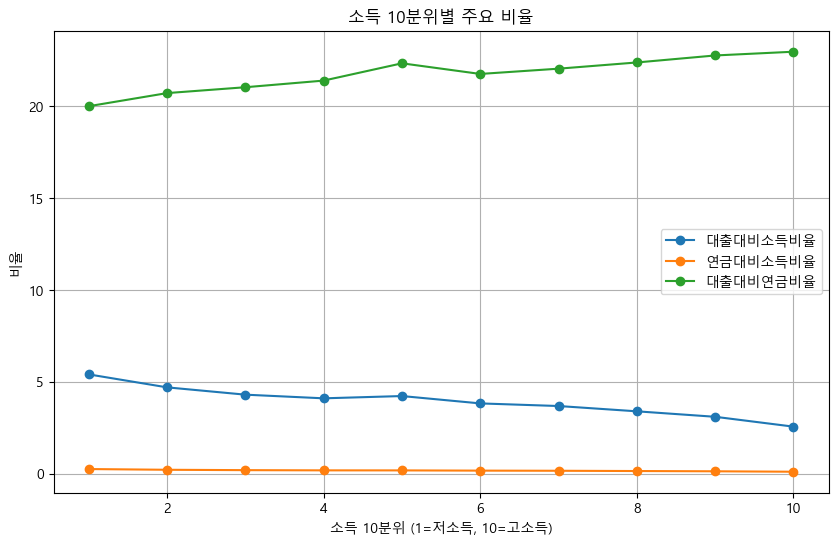

In [91]:
# df_ratio = 위 표 (index=소득_10분위, columns=3개 비율)
# index가 숫자가 아니라면 int로 변환
df_ratio.index = df_ratio.index.astype(int)

plt.figure(figsize=(10, 6))
plt.plot(df_ratio.index, df_ratio['대출대비소득비율'], marker='o', label='대출대비소득비율')
plt.plot(df_ratio.index, df_ratio['연금대비소득비율'], marker='o', label='연금대비소득비율')
plt.plot(df_ratio.index, df_ratio['대출대비연금비율'], marker='o', label='대출대비연금비율')

plt.title('소득 10분위별 주요 비율')
plt.xlabel('소득 10분위 (1=저소득, 10=고소득)')
plt.ylabel('비율')
plt.legend()
plt.grid(True)
plt.show()

#### 점수 로직 예시

In [ ]:
# 분위별 점수 (예: 100점 만점)
# 저소득 1분위 = 0점, 고소득 10분위 = 100점
income_score_map = {
    1: 0,
    2: 10,
    3: 20,
    4: 30,
    5: 40,
    6: 55,
    7: 65,
    8: 75,
    9: 85,
    10: 100
}

# df_income_ID_BIN: SK_ID_CURR, INCOME_BIN
df_income_ID_BIN['INCOME_SCORE'] = df_income_ID_BIN['INCOME_BIN'].map(income_score_map)


실제 비율을 기반으로 세밀하게 조정할 수 있음.  
예시: 대출대비소득비율이 5 이상이면 0점, 2 이하이면 100점, 그 사이 선형 보간 등

### 과거 신용조회 빈도 (AMT_REQ_CREDIT_BUREAU_*)

In [93]:
cols = [
    'AMT_REQ_CREDIT_BUREAU_HOUR',
    'AMT_REQ_CREDIT_BUREAU_DAY',
    'AMT_REQ_CREDIT_BUREAU_WEEK',
    'AMT_REQ_CREDIT_BUREAU_MON',
    'AMT_REQ_CREDIT_BUREAU_QRT',
    'AMT_REQ_CREDIT_BUREAU_YEAR'
]

for c in cols:
    print(f'\n=== {c} ===')
    print(df1[c].value_counts(dropna=False).sort_index().head)



=== AMT_REQ_CREDIT_BUREAU_HOUR ===
<bound method NDFrame.head of AMT_REQ_CREDIT_BUREAU_HOUR
0.0    264366
1.0      1560
2.0        56
3.0         9
4.0         1
NaN     41519
Name: count, dtype: int64>

=== AMT_REQ_CREDIT_BUREAU_DAY ===
<bound method NDFrame.head of AMT_REQ_CREDIT_BUREAU_DAY
0.0    264503
1.0      1292
2.0       106
3.0        45
4.0        26
5.0         9
6.0         8
8.0         1
9.0         2
NaN     41519
Name: count, dtype: int64>

=== AMT_REQ_CREDIT_BUREAU_WEEK ===
<bound method NDFrame.head of AMT_REQ_CREDIT_BUREAU_WEEK
0.0    257456
1.0      8208
2.0       199
3.0        58
4.0        34
5.0        10
6.0        20
7.0         2
8.0         5
NaN     41519
Name: count, dtype: int64>

=== AMT_REQ_CREDIT_BUREAU_MON ===
<bound method NDFrame.head of AMT_REQ_CREDIT_BUREAU_MON
0.0     222233
1.0      33147
2.0       5386
3.0       1991
4.0       1076
5.0        602
6.0        343
7.0        298
8.0        185
9.0        206
10.0       132
11.0       119
12.0   

- 대부분이 `0`이고, 3개월 QRT의 `261`은 이상치같음 (1개)  

**NaN이 전부 같은 행에만 나타남**  
- 신용조회 데이터 자체가 없는 고객  
- 이 고객들은 CB에 데이터가 전혀 없어서 모든 기간 컬럼이 NaN으로 채워진 것.

**처리 방법**
- NaN 전체를 0으로 치환
- 단, Flag를 하나 남겨두는 게 안전할 것으로 판단.

In [ ]:
# Bureau 조회 관련 모든 컬럼이 NaN인 경우를 flag
cols_bureau = [
    'AMT_REQ_CREDIT_BUREAU_HOUR',
    'AMT_REQ_CREDIT_BUREAU_DAY',
    'AMT_REQ_CREDIT_BUREAU_WEEK',
    'AMT_REQ_CREDIT_BUREAU_MON',
    'AMT_REQ_CREDIT_BUREAU_QRT',
    'AMT_REQ_CREDIT_BUREAU_YEAR'
]

df1['FLAG_BUREAU_REQ_ALL_NAN'] = df1[cols_bureau].isna().all(axis=1).astype(int)

# NaN은 0으로 채움
df1[cols_bureau] = df1[cols_bureau].fillna(0)

In [ ]:
# bin 구간 (바꿔도 됨)
def bin_inquiry(x):
    if x == 0:
        return "0회"
    elif x == 1:
        return "1회"
    elif x <= 5:
        return "2~5회"
    elif x <= 10:
        return "6~10회"
    else:
        return "10회 이상"

for col in cols_bureau:
    df1[col + '_BIN'] = df1[col].apply(bin_inquiry)

#### bad rate (연체율) 테이블 생성

In [ ]:
result_tables = {}
for col in cols_bureau:
    temp = (
        df1.groupby(col + '_BIN')
            .agg(
                count=('TARGET','size'),
                bad_rate=('TARGET','mean')
            )
            .reset_index()
            .sort_values('bad_rate', ascending=False)
    )
    result_tables[col] = temp

In [116]:
print(result_tables['AMT_REQ_CREDIT_BUREAU_YEAR'])
print('=' * 55)
print(result_tables['AMT_REQ_CREDIT_BUREAU_QRT'])

  AMT_REQ_CREDIT_BUREAU_YEAR_BIN   count  bad_rate
4                          6~10회   14081  0.091826
1                         10회 이상     119  0.084034
0                             0회  113320  0.083083
3                           2~5회  116586  0.081116
2                             1회   63405  0.073338
  AMT_REQ_CREDIT_BUREAU_QRT_BIN   count  bad_rate
1                        10회 이상       2  0.500000
4                         6~10회      42  0.190476
3                          2~5회   16669  0.083508
0                            0회  256936  0.082499
2                            1회   33862  0.065767


단순히 “조회가 많으면 위험”이 아니라,  
조회가 적당히 있는 사람은 오히려 낮은 위험이고  
조회가 없거나 매우 많은 사람은 위험한 U자형 패턴  

**QRT**  
`1회` 조회 고객이 가장 안전 (6%)   
`0회`와 `2~5회`는 비슷 (8% 정도)  
`6회 이상`은 위험 급등 (19%) - 이것도 표본이 많지는 않지만 연체율 높음  
`10회 이상`은 표본이 너무 작음    

**점수화 예시~**
- 1회: +10점
- 2~5회: +5점
- 0회: 0점
- 6~10회: -20점
- 10회 이상: -30점

In [120]:
display(result_tables['AMT_REQ_CREDIT_BUREAU_MON'])
display(result_tables['AMT_REQ_CREDIT_BUREAU_WEEK'])
display(result_tables['AMT_REQ_CREDIT_BUREAU_DAY'])
display(result_tables['AMT_REQ_CREDIT_BUREAU_HOUR'])

,AMT_REQ_CREDIT_BUREAU_MON_BIN,count,bad_rate
0,0회,263752,0.081922
2,1회,33147,0.077232
3,2~5회,9055,0.064826
4,6~10회,1164,0.051546
1,10회 이상,393,0.027990


,AMT_REQ_CREDIT_BUREAU_WEEK_BIN,count,bad_rate
2,2~5회,301,0.096346
0,0회,298975,0.080799
1,1회,8208,0.077729
3,6~10회,27,0.037037


,AMT_REQ_CREDIT_BUREAU_DAY_BIN,count,bad_rate
1,1회,1292,0.096749
2,2~5회,186,0.086022
0,0회,306022,0.080661
3,6~10회,11,0.000000


,AMT_REQ_CREDIT_BUREAU_HOUR_BIN,count,bad_rate
2,2~5회,66,0.090909
0,0회,305885,0.080730
1,1회,1560,0.080128


**1개월(MON), 1주(WEEK), 1일(DAY), 1시간(HOUR)**
- 짧은 기간 조회는 페널티 거의 없음, 0회면 오히려 약간 감점

**3개월(QRT), 1년(YEAR)**
- 6회 이상은 강력한 페널티, 0회도 thin-file 감점

In [ ]:
def score_bureau(bin_label, period):
    # bin_label: '0회', '1회', '2~5회', '6~10회', '10회 이상'
    if period in ['AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_REQ_CREDIT_BUREAU_QRT']:
        if bin_label == "0회": return -5
        elif bin_label == "1회": return 10
        elif bin_label == "2~5회": return 5
        else:  # 6~10회 or 10회 이상 (위험)
            return -20

    elif period == 'AMT_REQ_CREDIT_BUREAU_MON':
        if bin_label == "0회": return -5
        elif bin_label == "1회": return 2
        elif bin_label == "2~5회": return 5
        else:
            return 5  # 6회 이상도 가점 (연체율 2~5%로 낮음)

    else:  # WEEK, DAY, HOUR (구간별 연체율 차이 없음. 점수에 영향 X)
        return 0

weights = {
    'AMT_REQ_CREDIT_BUREAU_YEAR': 0.4,
    'AMT_REQ_CREDIT_BUREAU_QRT': 0.3,
    'AMT_REQ_CREDIT_BUREAU_MON': 0.2,
    'AMT_REQ_CREDIT_BUREAU_WEEK': 0.033,
    'AMT_REQ_CREDIT_BUREAU_DAY': 0.033,
    'AMT_REQ_CREDIT_BUREAU_HOUR': 0.033,
}

df1['INQUIRY_SCORE'] = 0
for col in cols_bureau:
    bin_col = col + '_BIN'
    df1['INQUIRY_SCORE'] += df1.apply(lambda x: score_bureau(x[bin_col], col) * weights[col], axis=1)

In [123]:
df1['INQUIRY_SCORE'].value_counts()

INQUIRY_SCORE
-4.5     94306
-0.5     74969
 1.5     45358
 4.0     14246
 0.9     13158
-10.5     8848
 6.0      8106
 2.9      7255
 2.5      7214
-3.1      6500
 0.0      6333
 4.5      3190
-2.5      2554
-1.5      2417
 3.5      2299
-6.0      1697
-7.5      1513
 5.4      1443
-9.1      1380
 3.9      1053
 7.4       755
 1.4       510
 5.9       432
 8.0       314
-8.5       309
-0.1       301
 2.0       251
-6.1       197
 6.5       166
-4.6       153
 0.5       139
-4.0        54
-5.5        47
-5.0        17
-9.0         8
-3.0         7
-3.6         7
-1.6         2
-15.0        2
-7.6         1
Name: count, dtype: int64

In [124]:
df1['INQUIRY_SCORE'] = np.round(df1['INQUIRY_SCORE'], 10)

In [125]:
df1['INQUIRY_SCORE'].value_counts()

INQUIRY_SCORE
-4.5     94306
-0.5     74969
 1.5     45358
 4.0     14246
 0.9     13158
-10.5     8848
 6.0      8106
 2.9      7255
 2.5      7214
-3.1      6500
 0.0      6333
 4.5      3190
-2.5      2554
-1.5      2417
 3.5      2299
-6.0      1697
-7.5      1513
 5.4      1443
-9.1      1380
 3.9      1053
 7.4       755
 1.4       510
 5.9       432
 8.0       314
-8.5       309
-0.1       301
 2.0       251
-6.1       197
 6.5       166
-4.6       153
 0.5       139
-4.0        54
-5.5        47
-5.0        17
-9.0         8
-3.0         7
-3.6         7
-1.6         2
-15.0        2
-7.6         1
Name: count, dtype: int64

##### `df_bureau`으로 따로 관리

In [99]:
cols_bureau = [
    'AMT_REQ_CREDIT_BUREAU_HOUR',
    'AMT_REQ_CREDIT_BUREAU_DAY',
    'AMT_REQ_CREDIT_BUREAU_WEEK',
    'AMT_REQ_CREDIT_BUREAU_MON',
    'AMT_REQ_CREDIT_BUREAU_QRT',
    'AMT_REQ_CREDIT_BUREAU_YEAR'
]

cols_bureau_bin = [
    'AMT_REQ_CREDIT_BUREAU_HOUR_BIN',
    'AMT_REQ_CREDIT_BUREAU_DAY_BIN',
    'AMT_REQ_CREDIT_BUREAU_WEEK_BIN',
    'AMT_REQ_CREDIT_BUREAU_MON_BIN',
    'AMT_REQ_CREDIT_BUREAU_QRT_BIN',
    'AMT_REQ_CREDIT_BUREAU_YEAR_BIN'
]

selected_cols = ['SK_ID_CURR'] + cols_bureau + cols_bureau_bin

df_bureau = df1[selected_cols].copy()

In [ ]:
df_bureau

In [131]:
vars_check = [
    'REGION_POPULATION_RELATIVE',
    'REGION_RATING_CLIENT',
    'REGION_RATING_CLIENT_W_CITY',
    'REG_REGION_NOT_LIVE_REGION',
    'REG_REGION_NOT_WORK_REGION',
    'LIVE_REGION_NOT_WORK_REGION',
    'REG_CITY_NOT_LIVE_CITY',
    'REG_CITY_NOT_WORK_CITY',
    'LIVE_CITY_NOT_WORK_CITY',
    'ORGANIZATION_TYPE'
]

for col in vars_check:
    print(f"\n==== {col} ====")
    display(df1.groupby(col)['TARGET'].agg(['count','mean']).sort_values('mean'))


==== REGION_POPULATION_RELATIVE ====


,count,mean
REGION_POPULATION_RELATIVE,,
0.000290,2,0.000000
0.072508,8412,0.039705
0.032561,6636,0.045660
0.046220,13442,0.049323
0.009175,2770,0.054152
...,...,...
0.001417,467,0.128480
0.008068,1668,0.136091
0.002134,1051,0.158896



==== REGION_RATING_CLIENT ====


,count,mean
REGION_RATING_CLIENT,,
1,32197,0.048203
2,226984,0.078891
3,48330,0.111028



==== REGION_RATING_CLIENT_W_CITY ====


,count,mean
REGION_RATING_CLIENT_W_CITY,,
1,34167,0.048409
2,229484,0.079178
3,43860,0.114022



==== REG_REGION_NOT_LIVE_REGION ====


,count,mean
REG_REGION_NOT_LIVE_REGION,,
0,302854,0.080540
1,4657,0.092978



==== REG_REGION_NOT_WORK_REGION ====


,count,mean
REG_REGION_NOT_WORK_REGION,,
0,291899,0.080291
1,15612,0.088906



==== LIVE_REGION_NOT_WORK_REGION ====


,count,mean
LIVE_REGION_NOT_WORK_REGION,,
0,295008,0.080571
1,12503,0.084460



==== REG_CITY_NOT_LIVE_CITY ====


,count,mean
REG_CITY_NOT_LIVE_CITY,,
0,283472,0.077207
1,24039,0.122260



==== REG_CITY_NOT_WORK_CITY ====


,count,mean
REG_CITY_NOT_WORK_CITY,,
0,236644,0.073127
1,70867,0.106114



==== LIVE_CITY_NOT_WORK_CITY ====


,count,mean
LIVE_CITY_NOT_WORK_CITY,,
0,252296,0.076585
1,55215,0.099665



==== ORGANIZATION_TYPE ====


,count,mean
ORGANIZATION_TYPE,,
Trade: type 4,64,0.031250
Industry: type 12,369,0.037940
Transport: type 1,201,0.044776
Trade: type 6,631,0.045959
Security Ministries,1974,0.048632
University,1327,0.048983
Police,2341,0.049979
Military,2634,0.051253
Bank,2507,0.051855


### `설명`

#### **1. REGION_POPULATION_RELATIVE (인구밀도)**
- 인구밀도가 낮을수록 bad_rate(연체율)이 높음  
   (0.0005 같은 극저밀도 지역은 20% 이상)
- 도시 (0.07 이상) 는 bad_rate 4~5%대 (안전)

**활용**  
- 분위별 binning 또는 임계값 구간화
   - 상위 30% (도시): 0점
   - 중간: -5점
   - 최하위 20% (극저밀도): -10점

#### **2. REGION_RATING_CLIENT_\* (지역 등급)**
- 1등급: 4.8%
- 2등급: 7.8%
- 3등급: 11.1%

**점수화**  
- 1: 0점
- 2: -5점
- 3: -10점

#### **3. 주소/직장 불일치 (Region/City Flags)**
**Region 단위 불일치**
- 차이가 크지 않음 (0 vs 1: 8.0% vs 9%대)

**City 단위 불일치**
- 도시 불일치가 명확하게 위험도 상승
   - `REG_CITY_NOT_LIVE_CITY`: 7.7% vs 12.2%
   - `REG_CITY_NOT_WORK_CITY`: 7.3% vs 10.6%

**점수화**
- City 불일치: -5점
- Region 불일치: -2점 (영향이 적음)

#### **4. ORGANIZATION_TYPE (조직 유형)**
- 낮은 bad_rate (안정적): 공공기관, 은행, 대학, 경찰, 군대 등
- 높은 bad_rate (위험): 식당(Restaurant), 운송 3, Industry 13, Industry 8 등

**점수화**
- 위험도가 높은 조직군만 -5~-10점
- 안전 직종은 0점
- XNA (미기재): 5.3% → 정보 없음 → -2점 정도

In [ ]:
df1.to_csv('./preprocessing/apllication_train_3.csv', index=False, encoding='utf-8-sig')

In [3]:
df = pd.read_csv('./preprocessing/apllication_train_3.csv')

In [ ]:
# 현재 직장 근속 기간
df['DAYS_EMPLOYED']

0           -637
1          -1188
2           -225
3          -3039
4          -3038
           ...  
307506      -236
307507    365243
307508     -7921
307509     -4786
307510     -1262
Name: DAYS_EMPLOYED, Length: 307511, dtype: int64

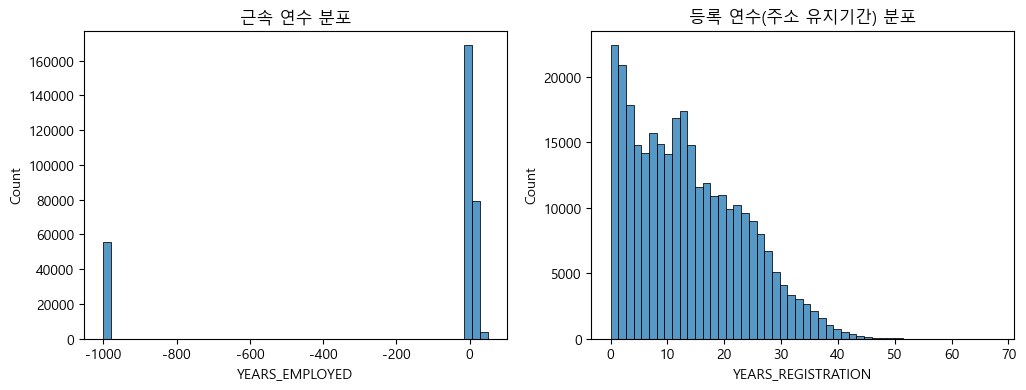

In [ ]:
# 음수를 양수로 변환 (일수 → 년수로 변환용)
df['YEARS_EMPLOYED'] = (-df['DAYS_EMPLOYED']) / 365
df['YEARS_REGISTRATION'] = (-df['DAYS_REGISTRATION']) / 365

# 근속 연수와 등록 연수 분포 확인
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df['YEARS_EMPLOYED'], bins=50, ax=axes[0])
axes[0].set_title("근속 연수 분포")
sns.histplot(df['YEARS_REGISTRATION'], bins=50, ax=axes[1])
axes[1].set_title("등록 연수(주소 유지기간) 분포")
plt.show()

In [23]:
# 특수값 비율 확인
special_val = 365243
print("365243,", (df['DAYS_EMPLOYED'] == special_val).sum())

# 특수값 제외한 분포
df_valid = df[df['DAYS_EMPLOYED'] != special_val].copy()

365243, 55374


#### 근속 연수, 1년 단위 구간화해서 카운트

In [24]:
# 근속 연수 (음수를 양수로 변환)
df_valid['YEARS_EMPLOYED'] = (-df_valid['DAYS_EMPLOYED']) / 365

In [32]:
# 최대 40년 정도까지 본다고 가정
bins = np.arange(0, 41, 1)  # 0,1,2,...40
df_valid['EMPLOYED_BIN'] = pd.cut(df_valid['YEARS_EMPLOYED'], bins=bins, right=False)

# 각 구간별 카운트
count_by_bin = df_valid['EMPLOYED_BIN'].value_counts().sort_index()
# print(count_by_bin)

In [26]:
pd.crosstab(df_valid['EMPLOYED_BIN'], df_valid['TARGET'])

TARGET,0,1
EMPLOYED_BIN,,
"[0, 1)",24839,3065
"[1, 2)",28210,3631
"[2, 3)",26474,3174
"[3, 4)",22557,2550
"[4, 5)",19782,1985
"[5, 6)",14946,1325
"[6, 7)",13898,1153
"[7, 8)",12192,956
"[8, 9)",10656,784


In [29]:
# 각 bin별 연체율 = sum(TARGET==1) / count
default_rate = (
    df_valid.groupby('EMPLOYED_BIN')['TARGET']
    .mean()  # mean() = 1의 비율
)

print(default_rate)

EMPLOYED_BIN
[0, 1)      0.109841
[1, 2)      0.114035
[2, 3)      0.107056
[3, 4)      0.101565
[4, 5)      0.091193
[5, 6)      0.081433
[6, 7)      0.076606
[7, 8)      0.072711
[8, 9)      0.068531
[9, 10)     0.063140
[10, 11)    0.063824
[11, 12)    0.056252
[12, 13)    0.054813
[13, 14)    0.056105
[14, 15)    0.055137
[15, 16)    0.049174
[16, 17)    0.048822
[17, 18)    0.048355
[18, 19)    0.048488
[19, 20)    0.047034
[20, 21)    0.041875
[21, 22)    0.050650
[22, 23)    0.043895
[23, 24)    0.051181
[24, 25)    0.053611
[25, 26)    0.048721
[26, 27)    0.027565
[27, 28)    0.022866
[28, 29)    0.050736
[29, 30)    0.049383
[30, 31)    0.048140
[31, 32)    0.034325
[32, 33)    0.054131
[33, 34)    0.036254
[34, 35)    0.032967
[35, 36)    0.023346
[36, 37)    0.015306
[37, 38)    0.007246
[38, 39)    0.017241
[39, 40)    0.032000
Name: TARGET, dtype: float64


C:\Users\COTTA\AppData\Local\Temp\ipykernel_4824\102121124.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_valid.groupby('EMPLOYED_BIN')['TARGET']


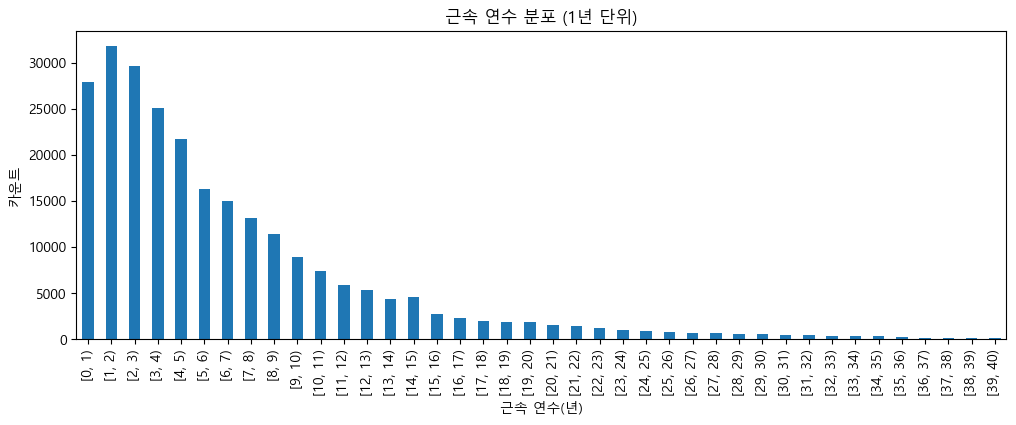

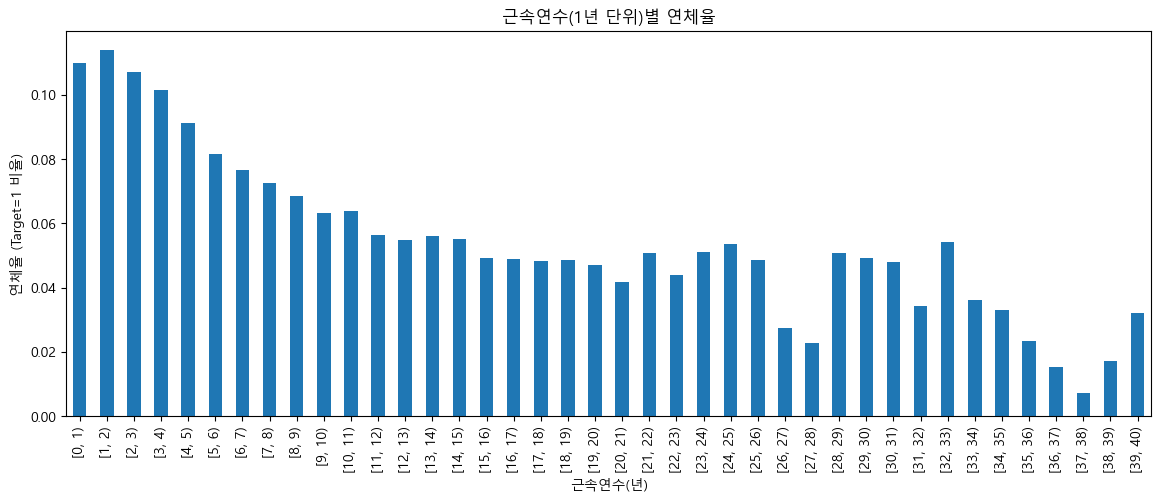

In [31]:
count_by_bin.plot(kind='bar', figsize=(12, 4))
plt.title("근속 연수 분포 (1년 단위)")
plt.xlabel("근속 연수(년)")
plt.ylabel("카운트")
plt.show()

default_rate.plot(kind='bar', figsize=(14, 5))
plt.title("근속연수(1년 단위)별 연체율")
plt.ylabel("연체율 (Target=1 비율)")
plt.xlabel("근속연수(년)")
plt.show()

**0~5년 미만**
- 연체율: 약 9~11%
- 특히 1~2년 미만은 11% 이상으로 가장 높음

**5~10년**
- 연체율이 점점 감소 (8% → 6%)

5년 이상 장기 근속자는 신용 리스크가 뚜렷하게 낮음  
0~2년 미만의 신규 근속자는 연체 위험이 확실히 높은 군집

In [33]:
bins = [0, 1, 2, 5, 10, 20, 40]
labels = ["1년 미만", "1~2년", "2~5년", "5~10년", "10~20년", "20년 이상"]
df_valid['EMPLOYED_GROUP'] = pd.cut(df_valid['YEARS_EMPLOYED'], bins=bins, labels=labels, right=False)

In [34]:
df_valid

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_DAY_BIN,AMT_REQ_CREDIT_BUREAU_WEEK_BIN,AMT_REQ_CREDIT_BUREAU_MON_BIN,AMT_REQ_CREDIT_BUREAU_QRT_BIN,AMT_REQ_CREDIT_BUREAU_YEAR_BIN,INQUIRY_SCORE,YEARS_EMPLOYED,YEARS_REGISTRATION,EMPLOYED_BIN,EMPLOYED_GROUP
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0회,0회,0회,0회,1회,1.5,1.745205,9.994521,"[1, 2)",1~2년
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0회,0회,0회,0회,0회,-4.5,3.254795,3.249315,"[3, 4)",2~5년
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0회,0회,0회,0회,0회,-4.5,0.616438,11.671233,"[0, 1)",1년 미만
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0회,0회,0회,0회,0회,-4.5,8.326027,26.939726,"[8, 9)",5~10년
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0회,0회,0회,0회,0회,-4.5,8.323288,11.810959,"[8, 9)",5~10년
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307504,456248,0,Cash loans,F,N,Y,0,153000.0,331920.0,16096.5,...,0회,0회,0회,0회,0회,-4.5,19.884932,26.843836,"[19, 20)",10~20년
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0회,0회,0회,0회,0회,-4.5,0.646575,23.167123,"[0, 1)",1년 미만
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0회,0회,1회,0회,1회,2.9,21.701370,18.457534,"[21, 22)",20년 이상
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0회,0회,0회,0회,0회,-4.5,13.112329,7.019178,"[13, 14)",10~20년


In [35]:
special_val = 365243

# 새 컬럼 초기화
df['EMPLOYED_GROUP'] = None

# 365243 → 연금수령자
df.loc[df['DAYS_EMPLOYED'] == special_val, 'EMPLOYED_GROUP'] = '연금수령자'

# 나머지 값 처리
df_working = df[df['DAYS_EMPLOYED'] != special_val].copy()
df_working['YEARS_EMPLOYED'] = (-df_working['DAYS_EMPLOYED']) / 365

# 구간 정의
bins = [0, 1, 2, 5, 10, 20, 40]
labels = ["1년 미만", "1~2년", "2~5년", "5~10년", "10~20년", "20년 이상"]

# binning
df.loc[df['DAYS_EMPLOYED'] != special_val, 'EMPLOYED_GROUP'] = pd.cut(
    df_working['YEARS_EMPLOYED'], bins=bins, labels=labels, right=False
)

In [37]:
df['EMPLOYED_GROUP']

0           1~2년
1           2~5년
2          1년 미만
3          5~10년
4          5~10년
           ...  
307506     1년 미만
307507     연금수령자
307508    20년 이상
307509    10~20년
307510      2~5년
Name: EMPLOYED_GROUP, Length: 307511, dtype: object

In [41]:
result = df.groupby('EMPLOYED_GROUP')['TARGET'].mean().sort_values(ascending=False)
result

EMPLOYED_GROUP
1~2년      0.114035
1년 미만     0.109841
2~5년      0.100742
5~10년     0.073740
10~20년    0.055151
연금수령자     0.053996
20년 이상    0.042600
Name: TARGET, dtype: float64

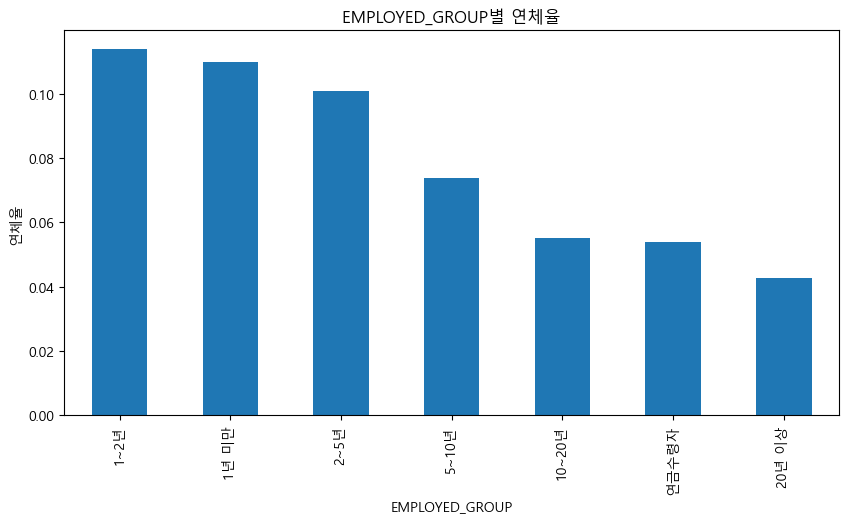

In [43]:
result.plot(kind='bar', figsize=(10, 5))
plt.title("EMPLOYED_GROUP별 연체율")
plt.ylabel("연체율")
plt.show()

In [45]:
df.to_csv('./preprocessing/apllication_train_4.csv', index=False, encoding='utf-8-sig')

In [ ]:
df['대출소득_bin'] = pd.qcut(df['대출대비소득비율'], q=10)  # 10분위
df.groupby('대출소득_bin')['TARGET'].mean().sort_index()

대출대비소득비율
0.0048    1.0
2.4272    1.0
2.9503    1.0
2.9570    1.0
2.9598    1.0
         ... 
3.8617    0.0
3.8615    0.0
3.8614    0.0
1.4339    0.0
4.1697    0.0
Name: TARGET, Length: 36262, dtype: float64

| 변수 이름               | 설명                                | 데이터 출처                   | 신용 관련 의미              |
| ------------------- | --------------------------------- | ------------------------ | --------------------- |
| `생활안정성_지표_1`        | 자녀 수 / 가족 수                       | `application_train`      | 가족 책임감 / 생활기반 안정성     |
| `주거기간 proxy`        | SAME\_APARTMENTS 비율 (과거와 동일한 주거지) | `application_train`      | 장기 거주 안정성             |
| `직업군별 지속성 점수`       | OCCUPATION\_TYPE별 평균 TARGET값 반영   | `application_train`      | 특정 직업의 연체율 기반 직업 안정성  |
| `가구 부양 부담지수`        | CNT\_CHILDREN / CNT\_FAM\_MEMBERS | `application_train`      | 부양비율이 높을수록 지출 부담 큼    |
| `카드활용 유지기간`         | 고객별 카드 사용 최장개월 수                  | `credit_card_balance`    | 금융거래 연속성              |
| `소액분할상환 선호도`        | 평균 납부금액이 낮고 납부 횟수는 많은 고객          | `installments_payments`  | 자금관리 성향 파악 가능         |
| `납부성실지수`            | 지연 없이 납부한 비율                      | `installments_payments`  | 책임감 있는 상환             |
| `대출 다변화 지수`         | 고객별 bureau 내 unique 대출 기관 수       | `bureau`                 | 여러 금융사 거래 경험 유무       |
| `연체 후 정상화 경험`       | 연체 → 회복된 사례 수                     | `bureau_balance`         | 신용 회복 가능성 추정          |
| `최근 대출 vs 과거 대출 비중` | 12개월 이내 대출 비중                     | `bureau` + `DAYS_CREDIT` | 갑작스런 대출 증가는 리스크일 수 있음 |

In [4]:
df2 = pd.read_csv('./preprocessing/apllication_train_4.csv')

In [5]:
result = (
    df2.groupby('소득_10분위')['OCCUPATION_TYPE']
       .agg(lambda x: x.value_counts().idxmax())
)

print(result)

소득_10분위
1     Laborers
2     Laborers
3     Laborers
4     Laborers
5     Laborers
6     Laborers
7     Laborers
8     Laborers
9     Laborers
10    Managers
Name: OCCUPATION_TYPE, dtype: object


In [7]:
result = (
    df2.groupby('소득_10분위')['OCCUPATION_TYPE']
       .agg(lambda x: x.value_counts().head(1))
)

# 보기 좋게 정리
result = result.reset_index()
print(result)


   소득_10분위  OCCUPATION_TYPE
0        1             4121
1        2             5128
2        3             6960
3        4             9898
4        5              754
5        6             6307
6        7             6388
7        8             8714
8        9             3524
9       10             6440


In [9]:
result = (
    df2.groupby('OCCUPATION_TYPE')['AMT_INCOME_TOTAL']
       .mean()
       .sort_values(ascending=False)
)

print(result)


OCCUPATION_TYPE
Managers                 260336.681717
IT staff                 213465.601711
Realty agents            195003.994674
Accountants              194578.357842
HR staff                 188916.282416
Drivers                  187011.606413
High skill tech staff    182842.045683
Private service staff    182334.812783
Core staff               172656.695254
Laborers                 166357.482525
Secretaries              160541.662069
Sales staff              152302.874710
Medicine staff           149709.643434
Security staff           149662.695953
Waiters/barmen staff     144272.583828
Cooking staff            138396.508176
Low-skill Laborers       133228.001911
Cleaning staff           130790.895551
Name: AMT_INCOME_TOTAL, dtype: float64


In [10]:
df2

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_HOUR_BIN,AMT_REQ_CREDIT_BUREAU_DAY_BIN,AMT_REQ_CREDIT_BUREAU_WEEK_BIN,AMT_REQ_CREDIT_BUREAU_MON_BIN,AMT_REQ_CREDIT_BUREAU_QRT_BIN,AMT_REQ_CREDIT_BUREAU_YEAR_BIN,INQUIRY_SCORE,YEARS_EMPLOYED,YEARS_REGISTRATION,EMPLOYED_GROUP
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0회,0회,0회,0회,0회,1회,1.5,1.745205,9.994521,1~2년
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0회,0회,0회,0회,0회,0회,-4.5,3.254795,3.249315,2~5년
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0회,0회,0회,0회,0회,0회,-4.5,0.616438,11.671233,1년 미만
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0회,0회,0회,0회,0회,0회,-4.5,8.326027,26.939726,5~10년
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0회,0회,0회,0회,0회,0회,-4.5,8.323288,11.810959,5~10년
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0회,0회,0회,0회,0회,0회,-4.5,0.646575,23.167123,1년 미만
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0회,0회,0회,0회,0회,0회,-4.5,-1000.665753,12.021918,연금수령자
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,1회,0회,0회,1회,0회,1회,2.9,21.701370,18.457534,20년 이상
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0회,0회,0회,0회,0회,0회,-4.5,13.112329,7.019178,10~20년
